In [1]:
from datetime import datetime
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
import os
import tensorflow as tf

2024-05-15 15:32:14.294447: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data Processing

In [2]:
sm_file_path = '~/Documents/lstm/cleandata/concatenated_data.csv'
om_file_path = '~/Documents/lstm/cleandata/OMNI_2010_2023.csv'

sm_data = pd.read_csv(sm_file_path)
om_data = pd.read_csv(om_file_path)

In [ ]:
sm_data = sm_data[['datetime', 'glon', 'glat', 'mlon', 'mlat', 'mlt','mcolat', 'dbn_geo', 'dbe_geo']]
# sm_data = sm_data[(sm_data['glon']>=190) & (sm_data['glon']<=340) & (sm_data['glat']>=25) & (sm_data['glat']<=49)]
sm_data = sm_data[(sm_data['glon']==282.63) & (sm_data['glat']==38.2)]
om_data = om_data[['DateTime', 'BX_GSE', 'BY_GSM', 'BZ_GSM', 'flow_speed', 'proton_density', 'T', 'Pressure']]
sm_data.sort_values(['glon', 'glat', 'datetime'], inplace=True)
print(sm_data.head(5))

In [ ]:
dataset = sm_data.merge(om_data, left_on='datetime', right_on='DateTime', how='left')
dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%Y-%m-%d %H:%M:%S')
# dataset['DateTime'] = dataset['DateTime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
dataset = dataset.dropna()
dataset.drop(columns=['DateTime'], inplace = True)
dataset = dataset[['datetime', 'BX_GSE', 'BY_GSM', 'BZ_GSM', 'flow_speed', 'proton_density', 'T', 'Pressure', 'glon', 'glat', 'mlon', 'mlat', 'mlt','mcolat', 'dbn_geo', 'dbe_geo']]
dataset.set_index('datetime', inplace=True)
print(dataset.head(5))
print(dataset.info())
# values = dataset.values

## Create LSTM ready dataset

In [5]:
#Split into train and test set
df_train = dataset[dataset.index < datetime(2020, 1, 1)]
df_test = dataset[dataset.index >= datetime(2020, 1, 1)]
print(df_train.shape, df_test.shape)

(1042065, 15) (353684, 15)


## Data Normalization

In [49]:
def normalize_df(train_df, test_df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(train_df)
    train_data = pd.DataFrame(scaler.transform(train_df), columns=train_df.columns, index=df_train.index)
    test_data = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns, index=df_test.index)
    return train_data, test_data

In [ ]:
data_train, data_test = normalize_df(df_train, df_test)
# print(data_train.head(5))
# print(data_test.tail(5))

In [51]:
def create_dataset(dataset, lookback):
    X, y = [], []
    dataset = pd.DataFrame(dataset)
    for i in range(len(dataset)-lookback):
        feature = dataset.iloc[i:i+lookback, :]
        target = dataset.iloc[i+lookback, -2:]
        X.append(feature)
        y.append(target)
    return np.asarray(X), np.asarray(y)

In [62]:
lookback = 1
train_X, train_y = create_dataset(data_train.values, lookback)
test_X, test_y = create_dataset(data_test, lookback)

In [53]:
# split into validation and test sets
val_size = int(test_X.shape[0] * 0.6)
# split into input and outputs
vld_X, vld_y = test_X[:val_size, :], test_y[:val_size, :]

print(train_X.shape, train_y.shape, vld_X.shape, vld_y.shape,test_X.shape, test_y.shape)
 

(1042064, 1, 15) (1042064, 2) (212209, 1, 15) (212209, 2) (353683, 1, 15) (353683, 2)


# LSTM Model

Epoch 1/50
2895/2895 - 6s - loss: 0.0015 - val_loss: 8.9620e-05
Epoch 2/50
2895/2895 - 6s - loss: 6.6578e-05 - val_loss: 1.3312e-05
Epoch 3/50
2895/2895 - 6s - loss: 3.8625e-05 - val_loss: 1.2015e-05
Epoch 4/50
2895/2895 - 6s - loss: 2.2844e-05 - val_loss: 1.3793e-05
Epoch 5/50
2895/2895 - 6s - loss: 3.1667e-05 - val_loss: 1.1724e-05
Epoch 6/50
2895/2895 - 6s - loss: 2.8381e-05 - val_loss: 1.1428e-05
Epoch 7/50
2895/2895 - 6s - loss: 3.2403e-05 - val_loss: 1.1531e-05
Epoch 8/50
2895/2895 - 6s - loss: 2.2578e-05 - val_loss: 1.1366e-05
Epoch 9/50
2895/2895 - 6s - loss: 3.0088e-05 - val_loss: 1.1589e-05
Epoch 10/50
2895/2895 - 6s - loss: 2.1456e-05 - val_loss: 1.1984e-05
Epoch 11/50
2895/2895 - 6s - loss: 2.8804e-05 - val_loss: 1.1429e-05
Epoch 12/50
2895/2895 - 5s - loss: 2.4221e-05 - val_loss: 1.1661e-05
Epoch 13/50
2895/2895 - 6s - loss: 2.3759e-05 - val_loss: 1.2380e-05
Epoch 14/50
2895/2895 - 6s - loss: 2.3743e-05 - val_loss: 1.2749e-05
Epoch 15/50
2895/2895 - 6s - loss: 2.7237e-05 -

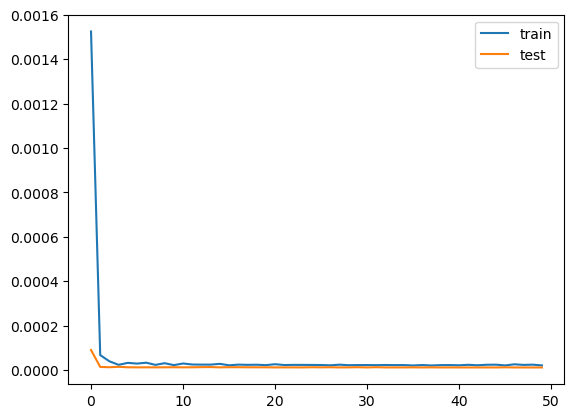

In [54]:
# design network
# from keras.optimizers import Adam
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(2))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=360, validation_data=(vld_X, vld_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig('loss_l.png')
pyplot.show()

# Data Prediction

In [63]:
yhat = model.predict(test_X)

train_max0 = np.max(df_train['dbn_geo'])
train_min0 = np.min(df_train['dbn_geo'])
train_max1 = np.max(df_train['dbe_geo'])
train_min1 = np.min(df_train['dbe_geo'])

test_y[:,0] = (test_y[:,0]*(train_max0-train_min0)+train_min0)*-1
test_y[:,1] = (test_y[:,1]*(train_max1-train_min1)+train_min1)*-1
yhat[:,0] = (yhat[:,0]*(train_max0-train_min0)+train_min0)*-1
yhat[:,1] = (yhat[:,1]*(train_max1-train_min1)+train_min1)*-1

rmse_1 = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
rmse_2 = sqrt(mean_squared_error(test_y[:,1], yhat[:,1]))
mae_1 = mean_absolute_error(test_y[:,0], yhat[:,0])
mae_2 = mean_absolute_error(test_y[:,1], yhat[:,1])
print('Test RMSE for dbn: %.3f' % rmse_1)
print('Test RMSE for dbe: %.3f' % rmse_2)
print('Test MAE for dbn: %.3f' % mae_1)
print('Test MAE for dbe: %.3f' % mae_2)

Test RMSE for dbn: 1.603
Test RMSE for dbe: 1.655
Test MAE for dbn: 0.937
Test MAE for dbe: 0.863


In [207]:
def predict_dbn(model, intial_sequence, steps):
    predicted_values = []
    current_sequence = intial_sequence.copy()
    for i in range(steps):
        predicted_value = model.predict(current_sequence.reshape(1, intial_sequence.shape[0], intial_sequence.shape[1]))
        predicted_values.append(predicted_value[0,0])
        current_sequence[:-1] = current_sequence[1:]
        current_sequence[-1] = predicted_value[0,0]
    return predicted_values

def predict_dbe(model, intial_sequence, steps):
    predicted_values = []
    current_sequence = intial_sequence.copy()
    for i in range(steps):
        predicted_value = model.predict(current_sequence.reshape(1, intial_sequence.shape[0], intial_sequence.shape[1]))
        predicted_values.append(predicted_value[0,1])
        current_sequence[:-1] = current_sequence[1:]
        current_sequence[-1] = predicted_value[0,1]
    return predicted_values

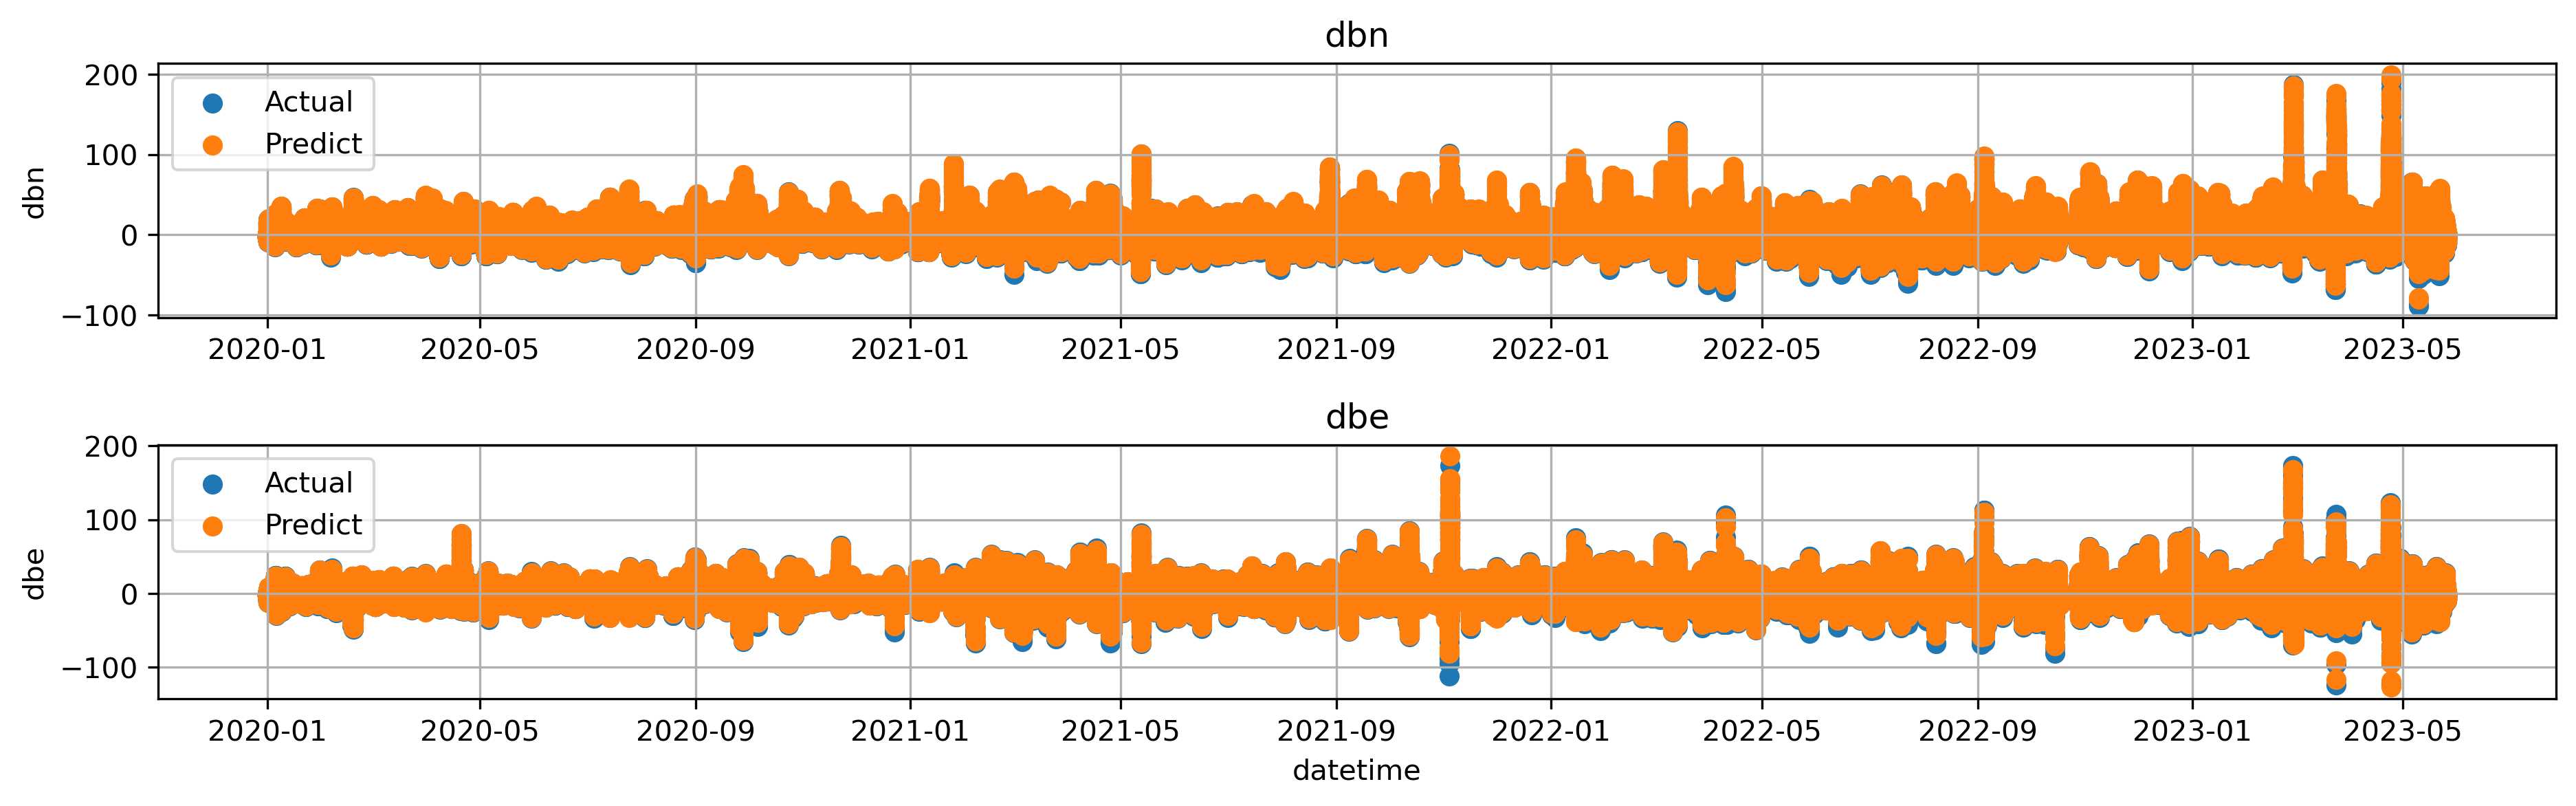

In [14]:
# steps = 8640
# # print(test_X[-1].shape)
# predicted_dbn = predict_dbn(model, test_X[-1], steps)
# predicted_dbe = predict_dbe(model, test_X[-1], steps)

# print(len(df_test.index))
# print(test_y.shape)
# print(len(pd.date_range(start='2023-05-26 01:50:00', end='2023-05-27 02:45:00', freq='5T')), len(series_dbn))
# series_dbn = np.array(predicted_dbn)*(train_max0-train_min0)+train_min0
# series_dbe = np.array(predicted_dbe)*(train_max1-train_min1)+train_min1
pyplot.figure(figsize=(15,4), dpi=300)
pyplot.subplot(2,1,1)
pyplot.scatter(df_test.index[1:], test_y[:,0], label='Actual')
pyplot.scatter(df_test.index[1:], yhat[:,0], label='Predict')
# pyplot.scatter(pd.date_range(start='2023-05-26 01:50:00', end='2023-06-25 01:45:00', freq='5T'), series_dbn, label='Recurring Prediction')
# pyplot.xlabel('datetime')
pyplot.ylabel('dbn')
pyplot.title('dbn')
pyplot.grid(True)
pyplot.legend()
pyplot.subplots_adjust(hspace=0.5)

pyplot.subplot(2,1,2)
pyplot.scatter(df_test.index[1:], test_y[:,1], label='Actual')
pyplot.scatter(df_test.index[1:], yhat[:,1], label='Predict')
# pyplot.scatter(pd.date_range(start='2023-05-26 01:50:00', end='2023-06-25 01:45:00', freq='5T'), series_dbe, label='Recurring Prediction')
pyplot.xlabel('datetime')
pyplot.ylabel('dbe')
pyplot.title('dbe')
pyplot.grid(True)
pyplot.legend()
pyplot.show()

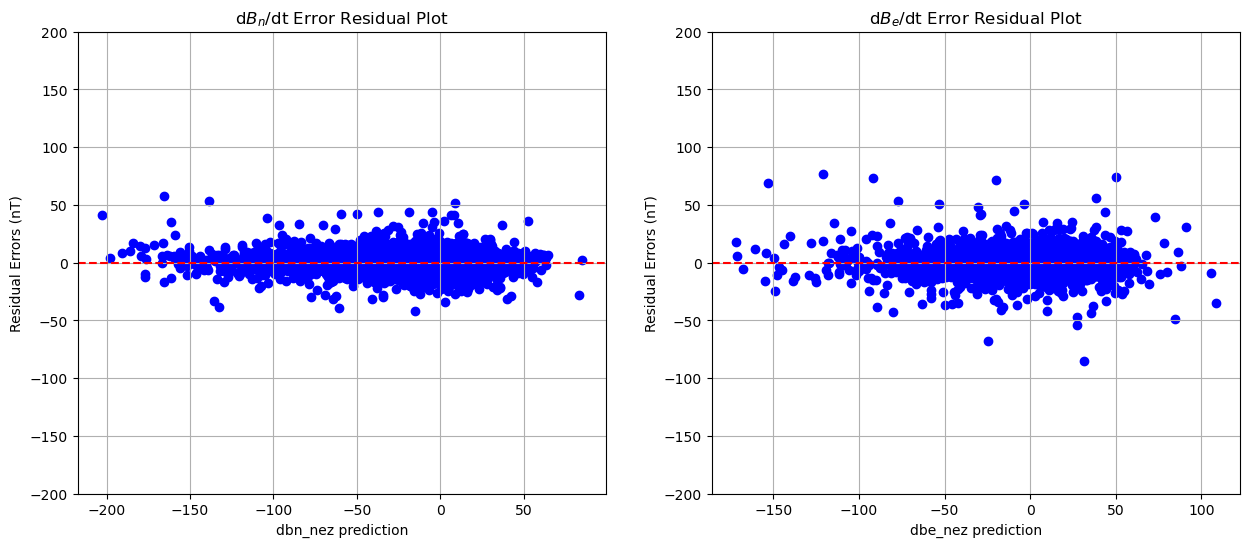

In [69]:
def plot_residual_errors(y_true, y_pred):
    pyplot.figure(figsize=(15, 6))

    pyplot.subplot(1, 2, 1)
    residuals = y_true[:, 0] - y_pred[:, 0]
    pyplot.scatter(y_pred[:, 0], residuals, c='blue')
    pyplot.axhline(0, color='r', linestyle='--', label='ideal')
    pyplot.ylim(-200, 200)
    pyplot.grid(True)
    pyplot.ylabel("Residual Errors (nT)")
    pyplot.xlabel("dbn_nez prediction")
    pyplot.title("d$B_n$/dt Error Residual Plot")

    pyplot.subplot(1, 2, 2)
    residuals = y_true[:,1] - y_pred[:, 1]
    pyplot.scatter(y_pred[:, 1], residuals, c='blue')
    pyplot.axhline(0, color='r', linestyle='--', label='ideal')
    pyplot.ylim(-200, 200)
    pyplot.grid(True)
    pyplot.ylabel("Residual Errors (nT)")
    pyplot.xlabel("dbe_nez prediction")
    pyplot.title("d$B_e$/dt Error Residual Plot")

    pyplot.show()

plot_residual_errors(test_y, yhat)

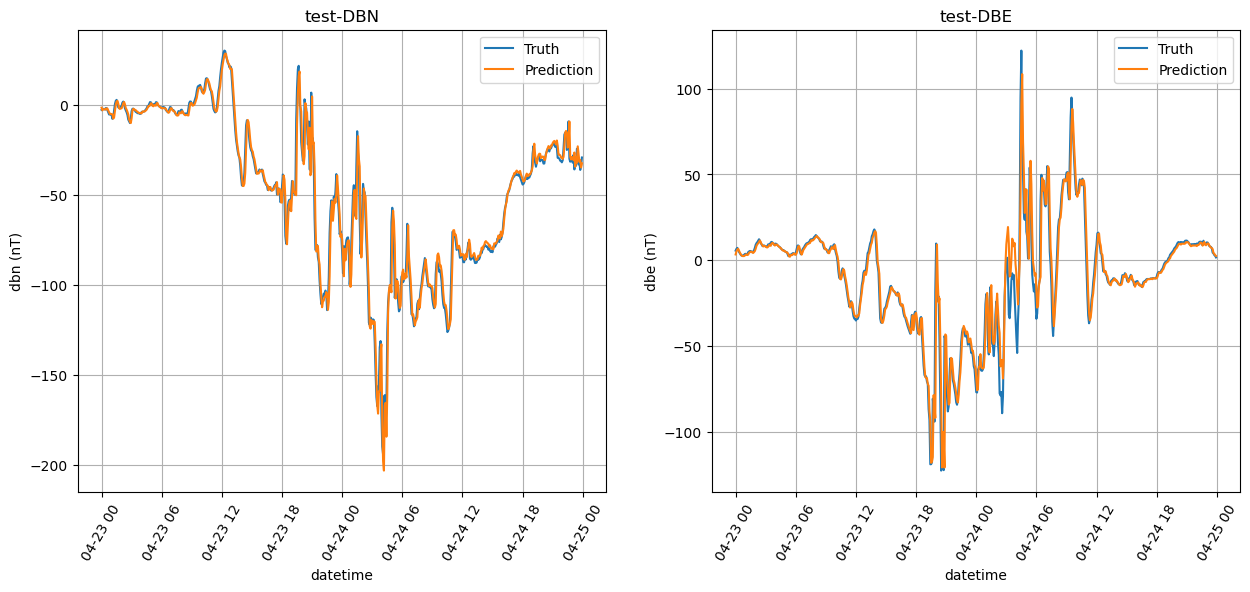

In [64]:
s_date = df_test.index.get_loc(datetime(2023, 4, 23))
e_date = df_test.index.get_loc(datetime(2023, 4, 25))

pyplot.figure(figsize=(15, 6))
pyplot.subplot(1,2,1)
pyplot.plot(df_test.index[s_date:e_date], test_y[s_date:e_date,0], label='Truth')
pyplot.plot(df_test.index[s_date:e_date], yhat[s_date:e_date,0], label='Prediction')
# pyplot.scatter(pd.date_range(start='2023-05-26 01:45:00', end='2023-05-26 02:45:00', freq='5T'), series[:0], label='Recurring Prediction')
pyplot.xlabel('datetime')
pyplot.xticks(rotation=60)
pyplot.ylabel('dbn (nT)')
pyplot.title('test-DBN')
pyplot.grid(True)
pyplot.legend()
pyplot.subplots_adjust(hspace=0.5)

pyplot.subplot(1,2,2)
pyplot.plot(df_test.index[s_date:e_date], test_y[s_date:e_date,1], label='Truth')
pyplot.plot(df_test.index[s_date:e_date], yhat[s_date:e_date,1], label='Prediction')
# pyplot.scatter(pd.date_range(start='2023-05-26 01:45:00', end='2023-05-26 02:45:00', freq='5T'), series[:1], label='Recurring Prediction')
pyplot.xlabel('datetime')
pyplot.xticks(rotation=60)
pyplot.ylabel('dbe (nT)')
pyplot.title('test-DBE')
pyplot.grid(True)
pyplot.legend()
pyplot.show()
